In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import gc

# 分布確認に使う
#import pandas_profiling as pdp
# 可視化
import matplotlib.pyplot as plt
# 前処理、特徴量作成 - sklearnを使う
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
# モデリング・精度と評価指標
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
#LGBM
import lightgbm as lgb

# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

# NOTE matplotでの日本語文字化けを解消
#pip install japanize-matplotlib
import japanize_matplotlib
%matplotlib inline

In [2]:
import pandas as pd
pd.options.display

train = pd.read_csv("train.csv", index_col=0) # 学習用データ
test = pd.read_csv("test.csv", index_col=0) # 学習用データ   # 評価用データ
sample_submit = pd.read_csv("sample_submission.csv", index_col=0, header=None) # 応募用サンプルファイル

In [3]:
train.head()

print("データ形状：")
print(train.shape)

print("データ数：")
print(len(train))

print("データのコラム数")
print(len(train.columns))

print("データ型一覧")
train.info()

データ形状：
(19984, 21)
データ数：
19984
データのコラム数
21
データ型一覧
<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  s

コラム数は全部で20個。ダミー化できるものはダミー化、そうでないものは分布数の多いもののみを取り出すなどの工夫をして
ドメイン知識を使った特徴量エンジニアリングをする。

In [4]:
print("データ型一覧")
train.info()

データ型一覧
<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  st_assem    19984 non-null  int64 
 20  cncl

tree_dbh, health, borocode, boro_ct, cb_num, st_senate, st_assem, cncldistで
ベースラインを作成する。その他本来ならint型にするべき値もベースラインに用いる

tree_dbh - 木の円周。量的変数
health - 木の健康状態、目的変数
borocode - ニューヨークの行政区分。質的変数
boro_ct - ニューヨーク市の行政区分（ボロー）の名称。質的変数
cb_num - コミュニティボード番号。質的変数
st_senate - 州上院地区番号。質的変数
st_assem - 州議会地区番号。質的変数
cncldist - 市議会の地区番号。質的変数

→使えるのはtree_dbhだけ。
次はstr・object型からint・float型に変換するべきものを探す

steward → 木の管理者数 
stewardはダミー化する。

tree_dbh,stewardの他にもまずは簡単にダミー化できる変数5つを使ってベースを作成する

In [5]:
print("データのコラム数")
print(train.columns)

データのコラム数
Index(['created_at', 'tree_dbh', 'curb_loc', 'health', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist'],
      dtype='object')


In [6]:
print("データのコラム数")
print(test.columns)

データのコラム数
Index(['created_at', 'tree_dbh', 'curb_loc', 'steward', 'guards', 'sidewalk',
       'user_type', 'problems', 'spc_common', 'spc_latin', 'nta', 'nta_name',
       'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num', 'st_senate',
       'st_assem', 'cncldist'],
      dtype='object')


In [7]:
#目的変数の分布を確認
counts = train["health"].value_counts()
counts

health
1    15751
0     3535
2      698
Name: count, dtype: int64

In [8]:
counts = counts.sort_index()

<Axes: xlabel='health'>

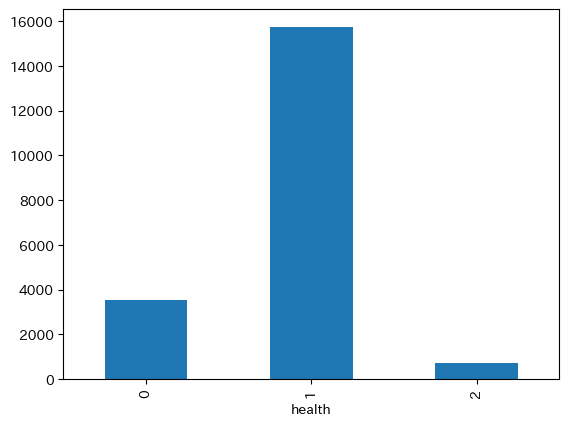

In [9]:
counts.plot.bar("health")

目的変数は1(good)であることが殆どだが、0や2(normal, bad)が約20%。

curb_loc
OnCurb            18777
OffsetFromCurb     1207
Name: count, dtype: int64


<Axes: xlabel='curb_loc'>

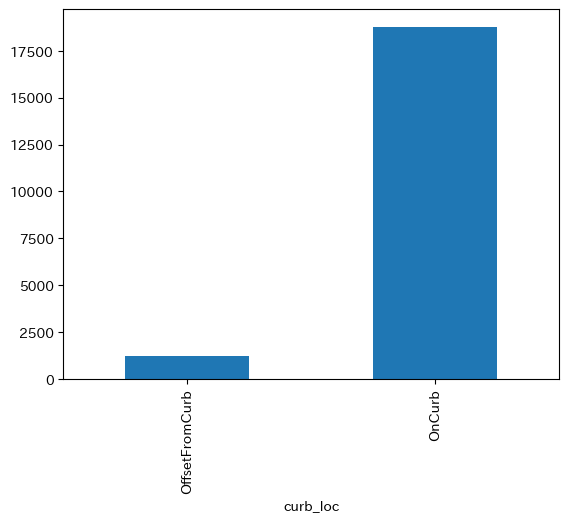

In [10]:
#目的変数の分布を確認
counts = train["curb_loc"].value_counts()
print(counts)
counts = counts.sort_index()
counts.plot.bar("curb_loc")

steward
1or2       3999
3or4       1079
4orMore      23
Name: count, dtype: int64


<Axes: xlabel='steward'>

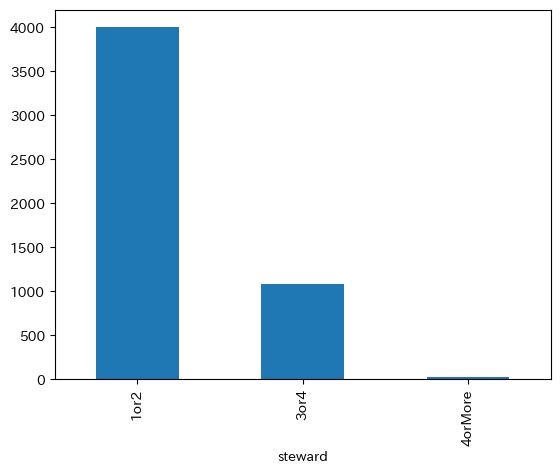

In [11]:
#目的変数の分布を確認
counts = train["steward"].value_counts()
print(counts)
counts = counts.sort_index()
counts.plot.bar("steward")

guards
Helpful    3650
Unsure      737
Harmful     654
Name: count, dtype: int64


<Axes: xlabel='guards'>

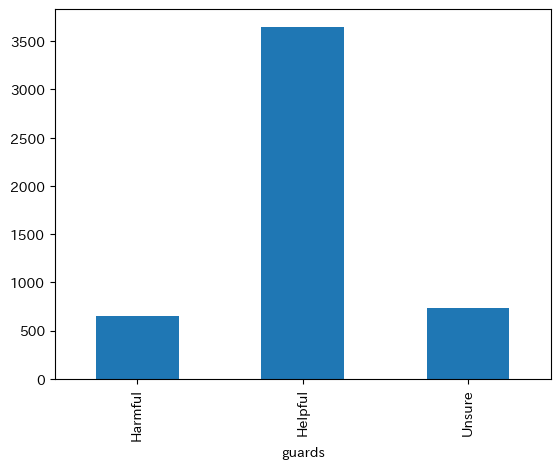

In [12]:
#目的変数の分布を確認
counts = train["guards"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("guards")

sidewalk
NoDamage    10689
Damage       9295
Name: count, dtype: int64


<Axes: xlabel='sidewalk'>

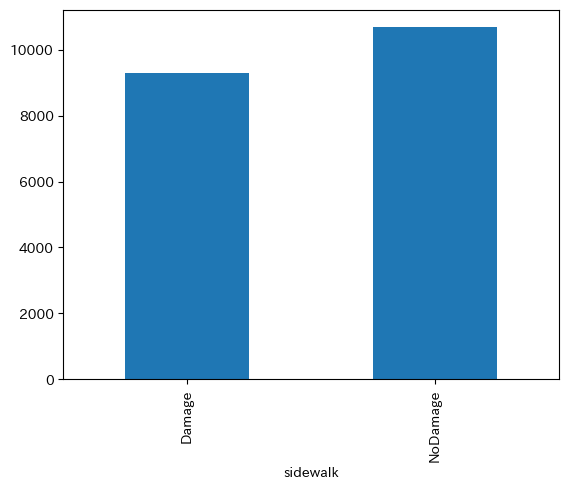

In [13]:
#目的変数の分布を確認
counts = train["sidewalk"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("sidewalk")

user_type
Volunteer           11189
TreesCount Staff     5795
NYC Parks Staff      3000
Name: count, dtype: int64


<Axes: xlabel='user_type'>

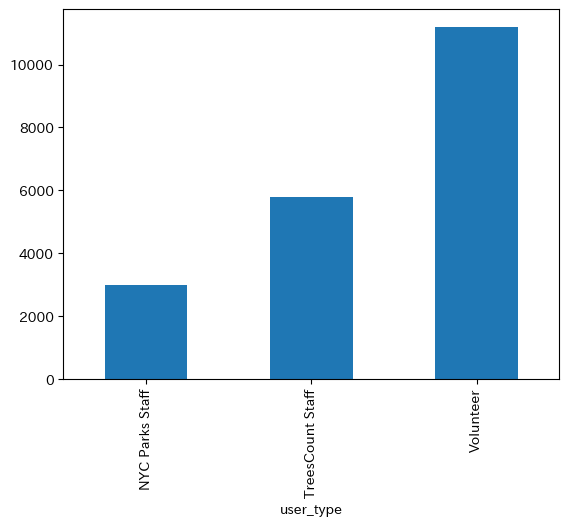

In [14]:
#目的変数の分布を確認
counts = train["user_type"].value_counts()
print(counts)

counts = counts.sort_index()
counts.plot.bar("user_type")

<Axes: >

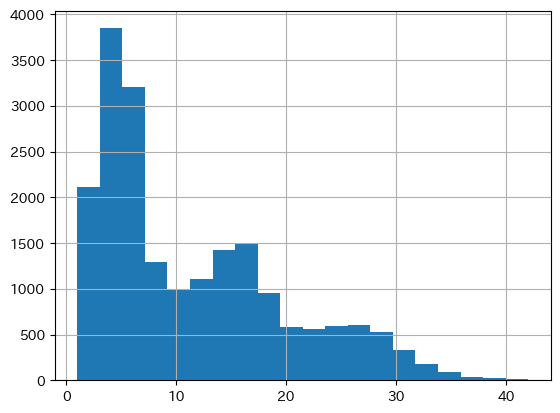

In [15]:
train["tree_dbh"].hist(bins=20)

→ ポアソン分布に近い。指数化すればより有効な値になるかも？

# 前処理

# ベースライン作成に用いる変数
tree_dbh
curb_loc
steward
guards
sidewalk
user_type

In [16]:
x_list = ["tree_dbh", "curb_loc","steward","guards","sidewalk","user_type"]
y_list = ["health"]
dummy_list = ["curb_loc","steward","guards","sidewalk","user_type"]

In [17]:
#　説明変数+目的変数とバリデーション設計
X_train, y_train = train[x_list], train[y_list]
X_train

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type
0,14,OnCurb,NaN,NaN,Damage,Volunteer
1,5,OnCurb,3or4,Helpful,NoDamage,Volunteer
2,26,OnCurb,NaN,NaN,NoDamage,Volunteer
3,15,OnCurb,NaN,NaN,Damage,NYC Parks Staff
4,23,OnCurb,NaN,NaN,NoDamage,Volunteer
...,...,...,...,...,...,...
19979,19,OnCurb,NaN,NaN,Damage,Volunteer
19980,5,OnCurb,NaN,NaN,NoDamage,NYC Parks Staff
19981,21,OnCurb,NaN,NaN,Damage,Volunteer
19982,4,OnCurb,1or2,NaN,NoDamage,NYC Parks Staff


In [18]:
y_train

,health
0,1
1,1
2,2
3,0
4,1
...,...
19979,2
19980,1
19981,0
19982,1


In [19]:
X_train.isnull().sum()

tree_dbh         0
curb_loc         0
steward      14883
guards       14943
sidewalk         0
user_type        0
dtype: int64

→　欠損値は'NULL'というカテゴリに置き換え、欠損であるという情報=質的変数の1つとして処理する

In [20]:
X_train.fillna('NULL', inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_10040\3412066468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna('NULL', inplace=True)


In [21]:
X_train.head(20)

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type
0,14,OnCurb,NULL,NULL,Damage,Volunteer
1,5,OnCurb,3or4,Helpful,NoDamage,Volunteer
2,26,OnCurb,NULL,NULL,NoDamage,Volunteer
3,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff
4,23,OnCurb,NULL,NULL,NoDamage,Volunteer
5,12,OnCurb,NULL,NULL,Damage,Volunteer
6,8,OnCurb,NULL,Helpful,Damage,Volunteer
7,6,OnCurb,NULL,NULL,NoDamage,NYC Parks Staff
8,18,OnCurb,NULL,NULL,Damage,TreesCount Staff
9,20,OnCurb,NULL,NULL,NoDamage,Volunteer


In [22]:
# problemsをbool変換 → 問題があるか否かのダミー変数にする
# train['bool_problems'] = train['problems'].apply(lambda x: 0 if x=='NULL' else 1)

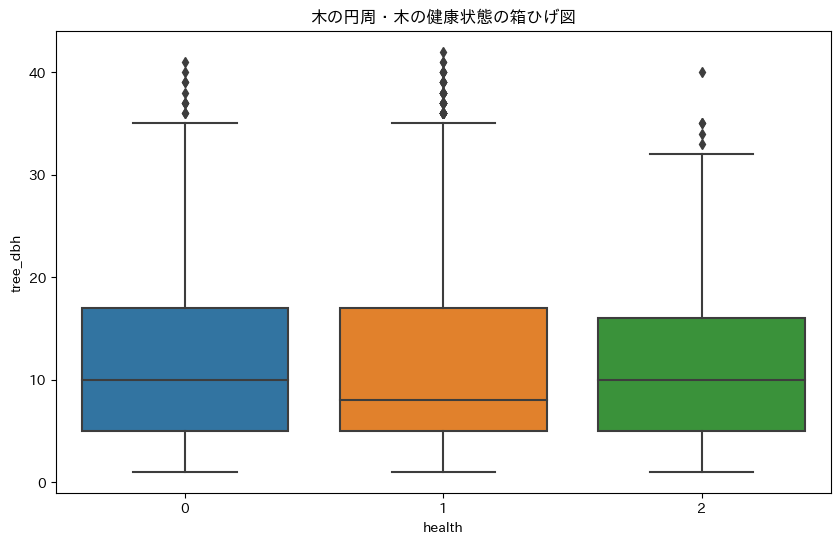

In [23]:
#　木の直径とhealthの関係
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

plt.figure(figsize=(10, 6))
sns.boxplot(x='health', y='tree_dbh', data=train)
plt.title('木の円周・木の健康状態の箱ひげ図')
plt.show()

→ badな木は若干円周が大きい。育ちすぎ等の原因があるかもしれない

# 特徴量エンジニアリング

今回の特徴量エンジニアリング

x_list = ["tree_dbh", "curb_loc","steward","guards","sidewalk","user_type"]
y_list = ["health"]
dummy_list = ["curb_loc","steward","guards","sidewalk","user_type"]

["curb_loc","steward","guards","sidewalk","user_type"]をダミー化する


In [24]:
X_train = pd.get_dummies(X_train, columns = dummy_list, drop_first=False)

In [25]:
X_train

,tree_dbh,curb_loc_OffsetFromCurb,curb_loc_OnCurb,steward_1or2,steward_3or4,steward_4orMore,steward_NULL,guards_Harmful,guards_Helpful,guards_NULL,guards_Unsure,sidewalk_Damage,sidewalk_NoDamage,user_type_NYC Parks Staff,user_type_TreesCount Staff,user_type_Volunteer
0,14,False,True,False,False,False,True,False,False,True,False,True,False,False,False,True
1,5,False,True,False,True,False,False,False,True,False,False,False,True,False,False,True
2,26,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True
3,15,False,True,False,False,False,True,False,False,True,False,True,False,True,False,False
4,23,False,True,False,False,False,True,False,False,True,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19979,19,False,True,False,False,False,True,False,False,True,False,True,False,False,False,True
19980,5,False,True,False,False,False,True,False,False,True,False,False,True,True,False,False
19981,21,False,True,False,False,False,True,False,False,True,False,True,False,False,False,True
19982,4,False,True,True,False,False,False,False,False,True,False,False,True,True,False,False


In [26]:
# ホールドアウト検証 - 学習用・テスト用の分割を1通り決める
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)

print("学習用・訓練用データの形状：")
print(X_tr.shape)
print(y_tr.shape)
print(X_va.shape)
print(y_va.shape)

学習用・訓練用データの形状：
(15987, 16)
(15987, 1)
(3997, 16)
(3997, 1)


In [27]:
# LGBMのパラメータ
params = {"boosting_type":"gbdt",
          "objective":"multiclass",
          "metric":"multi_logloss",
          "num_class":"3",
          "learning_rate":0.1,
          "num_leaves":20,
          "n_estimators":10000,
          "random_state":123,
          "importance_type":"gain",
          "early_stopping_round":100,
          "verbose":10
          }

# LGBMのモデル
model = lgb.LGBMClassifier(**params)
model.fit(X_tr, y_tr, eval_set=[(X_tr, y_tr),(X_va, y_va)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.886082
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.681602
[LightGBM] [Debug] init for col-wise cost 0.000955 seconds, init for row-wise cost 0.001090 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001670 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Sparse Multi-Val Bin
[LightGBM] [Info] Total Bins 72
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 16
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.732206
[LightGBM] [Info] Start training from score -0.238000
[LightGBM] [Info] Start training from score -3.355172
[LightGBM] [Debug] Tr

LGBMClassifier(early_stopping_round=100, importance_type='gain',
               metric='multi_logloss', n_estimators=10000, num_class='3',
               num_leaves=20, objective='multiclass', random_state=123,
               verbose=10)

In [28]:
# AUC値に加え精度を算出する
y_tr_pred = model.predict(X_tr)
y_va_pred = model.predict(X_va)

metric_tr = accuracy_score(y_tr, y_tr_pred)
metric_va = accuracy_score(y_va, y_va_pred)
print("モデル精度:")
print("学習精度")
print(metric_tr)
print("検証精度")
print(metric_va)

モデル精度:
学習精度
0.7882029148683305
検証精度
0.7880910683012259


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


valid_predictions = model.predict(X_va)
valid_f1 = f1_score(y_va, valid_predictions, average='macro')

print("マクロf1スコア：")
print(valid_f1)

マクロf1スコア：
0.2938295788442703


混合行列：
[[   0    0    0]
 [ 707 3150  140]
 [   0    0    0]]


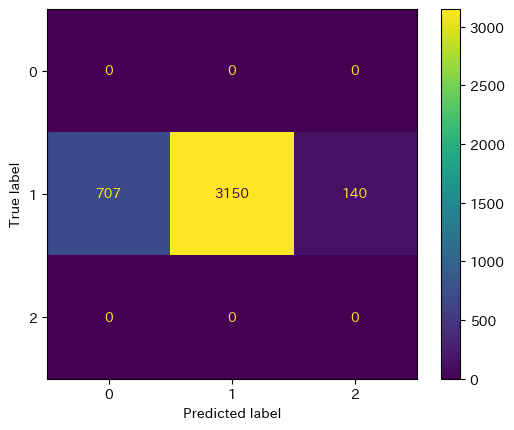

In [30]:
# 混合行列 - ラベルの正誤の分類数をまとめる
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_va_pred, y_va)
print("混合行列：")
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1","2"])
disp.plot()
plt.show()

→殆ど分類できていない。これでは分類には役立たないので要改善！！

In [37]:
# 寄与率算出
# feature importanceを表示
# importanceを表示する
importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance'])
impo02 = importance.sort_values(by="importance")
display(impo02)

,importance
curb_loc_OnCurb,15.06
sidewalk_NoDamage,15.88
steward_4orMore,28.97
steward_3or4,33.90
guards_Unsure,36.45
curb_loc_OffsetFromCurb,40.03
steward_NULL,52.12
guards_Helpful,60.63
guards_Harmful,65.60
user_type_TreesCount Staff,66.29


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

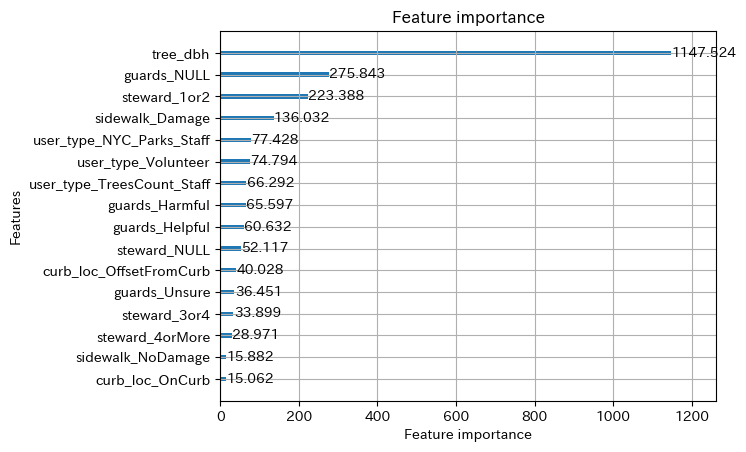

In [47]:
lgb.plot_importance(model)

In [44]:
X_train.columns

Index(['tree_dbh', 'curb_loc_OffsetFromCurb', 'curb_loc_OnCurb',
       'steward_1or2', 'steward_3or4', 'steward_4orMore', 'steward_NULL',
       'guards_Harmful', 'guards_Helpful', 'guards_NULL', 'guards_Unsure',
       'sidewalk_Damage', 'sidewalk_NoDamage', 'user_type_NYC Parks Staff',
       'user_type_TreesCount Staff', 'user_type_Volunteer'],
      dtype='object')

In [45]:
len(X_train.columns)

16

TypeError: only length-1 arrays can be converted to Python scalars

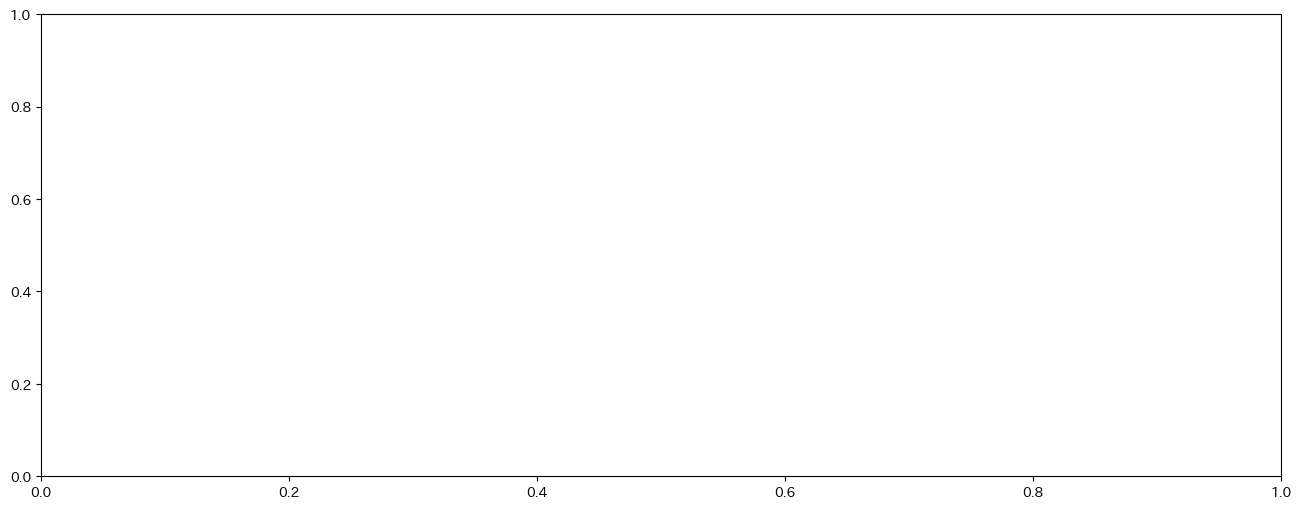

In [39]:
impo03 = pd.DataFrame(impo02)

In [40]:
impo03.plot.bar("importance")

TypeError: no numeric data to plot

In [32]:
import lazypredict
from lazypredict.Supervised import LazyClassifier

reg = LazyClassifier(ignore_warnings=True, random_state=1121, verbose=False,predictions=True)
models, predictions = reg.fit(X_tr, X_va, y_tr, y_va) 

print("モデルの精度・評価指標：")
display(models)
print("テストデータの予測値：")
display(predictions)

 93%|█████████▎| 27/29 [00:46<00:02,  1.07s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 15987, number of used features: 1
[LightGBM] [Info] Start training from score -1.732206
[LightGBM] [Info] Start training from score -0.238000
[LightGBM] [Info] Start training from score -3.355172


100%|██████████| 29/29 [00:47<00:00,  1.64s/it]

モデルの精度・評価指標：


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.10,0.35,None,0.05,0.67
KNeighborsClassifier,0.70,0.34,None,0.68,0.18
AdaBoostClassifier,0.79,0.33,None,0.69,0.36
XGBClassifier,0.79,0.33,None,0.69,0.72
LinearDiscriminantAnalysis,0.79,0.33,None,0.69,0.22
SVC,0.79,0.33,None,0.69,4.92
SGDClassifier,0.79,0.33,None,0.69,0.04
RidgeClassifierCV,0.79,0.33,None,0.69,0.04
RidgeClassifier,0.79,0.33,None,0.69,0.03


テストデータの予測値：


,AdaBoostClassifier,BaggingClassifier,BernoulliNB,CalibratedClassifierCV,DecisionTreeClassifier,DummyClassifier,ExtraTreeClassifier,ExtraTreesClassifier,GaussianNB,KNeighborsClassifier,...,PassiveAggressiveClassifier,Perceptron,QuadraticDiscriminantAnalysis,RandomForestClassifier,RidgeClassifier,RidgeClassifierCV,SGDClassifier,SVC,XGBClassifier,LGBMClassifier
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3992,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3993,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3994,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3995,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1


# 投稿用データを作成

In [33]:
# 説明変数・目的変数
X_test = test[x_list]
X_test

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type
19984,15,OnCurb,NaN,NaN,Damage,NYC Parks Staff
19985,5,OnCurb,1or2,NaN,NoDamage,Volunteer
19986,4,OnCurb,NaN,Unsure,NoDamage,Volunteer
19987,7,OnCurb,NaN,NaN,NoDamage,TreesCount Staff
19988,6,OnCurb,1or2,Helpful,NoDamage,TreesCount Staff
...,...,...,...,...,...,...
39964,3,OnCurb,1or2,Harmful,Damage,Volunteer
39965,9,OnCurb,1or2,NaN,NoDamage,NYC Parks Staff
39966,16,OnCurb,NaN,NaN,Damage,Volunteer
39967,24,OnCurb,NaN,NaN,Damage,TreesCount Staff


In [34]:
# 欠損値補完
X_test.fillna('NULL', inplace=True)

#ダミー化
X_test = pd.get_dummies(X_test, columns = dummy_list, drop_first=True)

In [35]:
# 予測
y_test_pred = model.predict(X_test)
y_test_pred

ValueError: Number of features of the model must match the input. Model n_features_ is 16 and input n_features is 11

In [ ]:
# NOTE 予測結果を1次元ベクトルにする
y_test_pred = np.squeeze(y_test_pred)
y_test_pred.shape
y_test_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [ ]:
sample_submit[1] = y_test_pred
sample_submit.to_csv('submit_lgbm_baseline01.csv', header=None)